# Electric Field Errors Test

A notebook to try out converting my MATLAB function for calculating error metrics between two complex electric fields into Python. As sample data to test this out with, I will utilize the NF data provided with the MATLAB NF2FF script, along with a jittered version that I'll create in MATLAB just for purpose of getting some type of errors. This will allow for compariosn of results between the Python and MATLAB functions.

In [101]:
## import statements:
import numpy as np
from matplotlib.pyplot import *
from numpy.fft import fft2
from numpy.fft import ifft2
from numpy.fft import fftshift
from numpy.fft import ifftshift
from scipy.interpolate import interp2d

from electric_field_errors import *

import pandas
from matplotlib.colors import LogNorm

In [102]:
# importing my exported MATLAB data into the Python notebook and creating a colormesh map

# NF_X_Complex_mag=np.abs(NF_X_Complex)
# NF_Y_Complex_mag=np.abs(NF_Y_Complex)
# NF_X_Complex_jittered_mag=np.abs(NF_X_Complex_jittered)
# NF_Y_Complex_jittered_mag=np.abs(NF_Y_Complex_jittered)

In [103]:
# adopting Will's method for the electric field

c=299792458.0 # Speed of light in vacuum [m/s]
sdata=np.array(pandas.read_csv('sample_data.csv',header=None)).flatten()
sdata=np.array([complex(x.replace('i','j')) for x in sdata]).reshape((51,51,201))
sdata2=np.array(pandas.read_csv('s21_data2.csv',header=None)).flatten()
sdata2=np.array([complex(x.replace('i','j')) for x in sdata2]).reshape((51,51,201))
freq=np.loadtxt('sample_frequencies.csv',delimiter=',') #Hz

f_index = 200
f=freq[200]

NF_X_Complex=sdata[:,:,f_index]
NF_Y_Complex=sdata2[:,:,f_index]
NF_X_Magnitude = (np.abs(NF_X_Complex));
NF_Y_Magnitude = (np.abs(NF_Y_Complex));

In [104]:
print(NF_X_Complex)

[[ 1.316814e-04+3.142221e-04j -2.796135e-04+2.792703e-04j
  -9.613120e-04+8.221177e-04j ... -8.734243e-04-1.994218e-04j
  -3.239681e-04+1.331172e-03j -5.729367e-04-9.751501e-04j]
 [ 4.302898e-04+4.187999e-04j -2.240537e-04-2.821987e-04j
  -3.995839e-04-8.410797e-04j ... -3.337284e-04-1.157538e-03j
  -3.228649e-04+1.084881e-04j  1.167116e-04+9.710135e-04j]
 [-9.349172e-04+1.286089e-03j -1.784160e-04-6.998545e-04j
   5.156870e-04-3.310335e-04j ...  2.318110e-04-3.497407e-04j
  -1.232173e-03+1.295951e-04j -4.619499e-05-3.758743e-04j]
 ...
 [-1.514508e-04+7.772083e-05j  9.509416e-04+3.542719e-04j
  -3.126048e-04-2.890350e-05j ... -7.796406e-06+1.113046e-03j
   1.710060e-05+9.623382e-04j  4.305376e-04-3.029575e-04j]
 [-4.456199e-04+3.705956e-04j -8.229939e-04-1.035962e-04j
  -1.610670e-04-7.248778e-05j ...  7.317069e-04+7.894461e-04j
   3.746579e-04+8.460503e-04j  6.547969e-04-2.189510e-04j]
 [ 8.306931e-04+6.752512e-04j  3.009925e-04-2.539283e-04j
  -1.159975e-04+5.858942e-04j ...  8.63420

In [105]:
# gridding

M = np.shape(NF_X_Complex)[1]
N = np.shape(NF_X_Complex)[0]
dx=1/1000#sdata.x_step/1000; # Sample spacing in the x direction [m]
dy=1/1000#sdata.y_step/1000; # Sample spacing in the y direction [m]
a=dx*(M-1); # The length of the scanned area in the x direction [m]
b=dy*(N-1); # The length of the scanned area in the y direction [m]
x=np.linspace(-a/2,a/2,M)
y=np.linspace(-b/2,b/2,N)
z0=0.006;

# See equations (16-13a) and (16-13b) in Balanis
# Zero padding is used to increase the resolution of the plane wave spectral domain.
MI=4*M;#2^(ceil(log2(M))+1);
NI=4*N;#2^(ceil(log2(N))+1);
m=np.linspace(-MI/2,MI/2-1,MI);
n=np.linspace(-NI/2,NI/2-1,NI)

broadcast_freq=94*10^9 # broadcast frequency in hertz
lambda_m=c/broadcast_freq
nyquist_sampling_m=lambda_m/2 # necessary grid spacing in m
max_drift_percent=0.1
max_drift=nyquist_sampling_m*max_drift_percent

<ipython-input-106-a6bdf08f1401>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm=ax[i].pcolormesh(x*1000,y*1000,data[i])


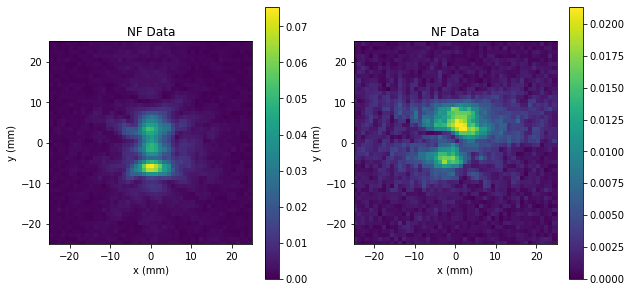

In [106]:
fig, ax=subplots(1,2,figsize=(10,5))

data=[NF_X_Magnitude,NF_Y_Magnitude]

for i in range(len(ax)):
    pcm=ax[i].pcolormesh(x*1000,y*1000,data[i])
    ax[i].set_aspect('equal')
    ax[i].set_title('NF Data')
    ax[i].set_xlabel('x (mm)')
    ax[i].set_ylabel('y (mm)')
    colorbar(mappable=pcm,ax=ax[i])

In [107]:
# creating the offset stuff
x_offsets=np.linspace(0,max_drift,M)
y_offsets=np.linspace(0,max_drift,N)
x_drifted=x+x_offsets
y_drifted=y+y_offsets
[x_drifted_grid,y_drifted_grid]=np.meshgrid(x_drifted,y_drifted)

NF_X_Real = np.real(NF_X_Complex)
NF_X_Imag = np.imag(NF_X_Complex)
NF_Y_Real = np.real(NF_Y_Complex)
NF_Y_Imag = np.imag(NF_Y_Complex)

# interpolating for 2d data--must do real and complex separately due to scipy interp2d function
NF_X_Real_Interpolation = interp2d(x,y,NF_X_Real,kind='cubic')
NF_X_Imag_Interpolation = interp2d(x,y,NF_X_Imag,kind='cubic')
NF_Y_Real_Interpolation = interp2d(x,y,NF_Y_Real,kind='cubic')
NF_Y_Imag_Interpolation = interp2d(x,y,NF_Y_Imag,kind='cubic')
NF_X_Drifted_Real = NF_X_Real_Interpolation(x_drifted,y_drifted)
NF_X_Drifted_Imag = NF_X_Imag_Interpolation(x_drifted,y_drifted)
NF_Y_Drifted_Real = NF_Y_Real_Interpolation(x_drifted,y_drifted)
NF_Y_Drifted_Imag = NF_Y_Imag_Interpolation(x_drifted,y_drifted)

# putting them together into drifted complex field
NF_X_Drifted = NF_X_Drifted_Real + 1j*NF_X_Drifted_Imag
NF_Y_Drifted = NF_Y_Drifted_Real + 1j*NF_Y_Drifted_Imag

In [108]:
NF_X_Drifted
NF_Y_Drifted

array([[-0.00047799+0.00110878j,  0.0003224 -0.00011346j,
         0.0003224 -0.00011346j, ...,  0.0003224 -0.00011346j,
         0.0003224 -0.00011346j,  0.0003224 -0.00011346j],
       [ 0.00106231-0.00060626j,  0.00012943-0.00079387j,
         0.00012943-0.00079387j, ...,  0.00012943-0.00079387j,
         0.00012943-0.00079387j,  0.00012943-0.00079387j],
       [ 0.00106231-0.00060626j,  0.00012943-0.00079387j,
         0.00012943-0.00079387j, ...,  0.00012943-0.00079387j,
         0.00012943-0.00079387j,  0.00012943-0.00079387j],
       ...,
       [ 0.00106231-0.00060626j,  0.00012943-0.00079387j,
         0.00012943-0.00079387j, ...,  0.00012943-0.00079387j,
         0.00012943-0.00079387j,  0.00012943-0.00079387j],
       [ 0.00106231-0.00060626j,  0.00012943-0.00079387j,
         0.00012943-0.00079387j, ...,  0.00012943-0.00079387j,
         0.00012943-0.00079387j,  0.00012943-0.00079387j],
       [ 0.00106231-0.00060626j,  0.00012943-0.00079387j,
         0.00012943-0.00079387

<ipython-input-109-ee12da5931c5>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm=ax[i].pcolormesh(x*1000,y*1000,data[i])


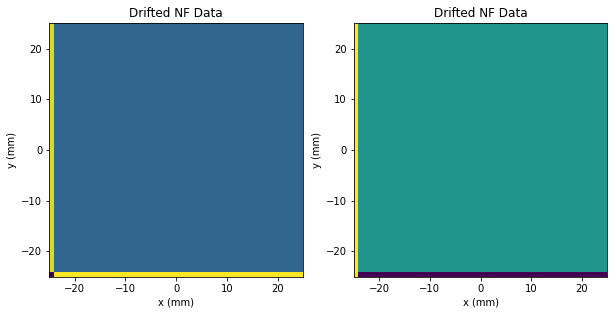

In [109]:
# plotting the drifted data
NF_X_Drifted_mag = np.abs(NF_X_Drifted)
NF_Y_Drifted_mag = np.abs(NF_Y_Drifted)

fig, ax=subplots(1,2,figsize=(10,5))

data=[NF_X_Drifted_mag,NF_Y_Drifted_mag]

for i in range(len(ax)):
    pcm=ax[i].pcolormesh(x*1000,y*1000,data[i])
    ax[i].set_aspect('equal')
    ax[i].set_title('Drifted NF Data')
    ax[i].set_xlabel('x (mm)')
    ax[i].set_ylabel('y (mm)')
#     colorbar(mappable=pcm,ax=ax[i])

In [110]:
def exclude_7sigma_outliers(data):
    '''This function excludes outliers >7sigma from the mean value. 
    This may seem rare, but with this type of transformation, occurs more commonly than one might think.'''
    sigma_data=np.std(data)
    preliminary_mean=np.mean(data)
    data[np.abs((data-preliminary_mean) > (7*sigma_data))]=float('nan')
    
    return data


In [111]:
# This is ok, I just need stuff to test on

def electric_field_errors1 (original_field,perturbed_field,x,y,label_1,label_2,outputs=0):
    # takes in as inputs two electric fields, and the labels for axes on plots
    # x and y are values along the two axes (theta and phi for a far-field pattern)
    # set outputs to 1 if want text and plot outputs. 0 (default) supresses outputs
    
    [x_grid,y_grid]=np.meshgrid(x,y)
    
    error_metrics={} # making a dictionary to store the error metrics. Eventually, hopefully this will be
                     # its own class or contained within an electric field class set
    error_metrics['error']=perturbed_field-original_field
    error_real=error_metrics['error'].real
    error_im=error_metrics['error'].imag
    original_field_real=original_field.real
    original_field_im=original_field.imag
    perturbed_field_real=perturbed_field.real
    perturbed_field_im=perturbed_field.imag
    error_metrics['error_amplitude']=np.abs(error_metrics['error'])
    error_metrics['error_phase']=np.angle(error_metrics['error'])
    original_field_amplitude=np.abs(original_field)
    perturbed_field_amplitude=np.abs(perturbed_field)
    original_field_phase=np.angle(original_field)
    perturbed_field_phase=np.angle(perturbed_field)
    
    error_real=exclude_7sigma_outliers(error_real)
    error_im=exclude_7sigma_outliers(error_im)
    
    # calculating weighted percent difference
    # As a vector difference of real and imaginary components
    weighted_percent_difference_real=np.divide(error_real,((original_field_real+perturbed_field_real)/2))
    weighted_percent_difference_im=np.divide(error_im,(original_field_im+perturbed_field_im)/2)
    error_metrics['weighted_percent_difference']= weighted_percent_difference_real + 1j*weighted_percent_difference_im
    error_metrics['weighted_percent_difference_amplitude']=np.abs(error_metrics['weighted_percent_difference'])
    error_metrics['weighted_percent_difference_phase']=np.angle(error_metrics['weighted_percent_difference'])
    # Method 1 for mean: taking mean of amplitude and phase errors
    error_metrics['weighted_percent_difference_amplitude_mean']=np.nanmean(error_metrics['weighted_percent_difference_amplitude'])
    error_metrics['weighted_percent_difference_phase_mean']=np.nanmean(error_metrics['weighted_percent_difference_phase'])
    # Method 2: finding mean weighted percent difference by averaging real and imaginary components separately
    weighted_percent_difference_real_mean=np.nanmean(weighted_percent_difference_real)
    weighted_percent_difference_im_mean=np.nanmean(weighted_percent_difference_im)
    error_metrics['weighted_percent_difference_mean']=weighted_percent_difference_real_mean + 1j*weighted_percent_difference_im_mean
    error_metrics['weighted_percent_difference_mean_amplitude']=np.abs(error_metrics['weighted_percent_difference_mean'])
    error_metrics['weighted_percent_difference_mean_phase']=np.angle(error_metrics['weighted_percent_difference_mean'])
    
    # range of the error--calculated as max - min of the error (complex subtraction between the two fields)
    error_range_real=np.nanmax(error_real)-np.nanmin(error_real)
    error_range_im=np.nanmax(error_im)-np.nanmin(error_im)
    error_metrics['error_range']=error_range_real + 1j*error_range_im
    error_metrics['error_range_amplitude']=np.abs(error_metrics['error_range'])
    error_metrics['error_range_phase']=np.angle(error_metrics['error_range'])
    # doing the same for the weighted percent difference
    pct_difference_range_real=np.nanmax(weighted_percent_difference_real) - np.nanmin(weighted_percent_difference_real)
    pct_difference_range_im = np.nanmax(weighted_percent_difference_im) - np.nanmin(weighted_percent_difference_im)
    error_metrics['pct_difference_range'] = pct_difference_range_real + 1j*pct_difference_range_im
    error_metrics['pct_difference_range_amplitude'] = np.abs(error_metrics['pct_difference_range'])
    error_metrics['pct_difference_range_phase'] = np.angle(error_metrics['pct_difference_range'])
    
    # standard deviation of the error
    std_error_real=np.nanstd(error_real)
    std_error_im=np.nanstd(error_im)
    error_metrics['std_error'] = std_error_real + 1j*std_error_im
    error_metrics['std_error_amplitude'] = np.abs(error_metrics['std_error'])
    error_metrics['std_error_phase'] = np.angle(error_metrics['std_error'])
    # standard deviation of the percent error
    pct_diff_std_error_real = np.nanstd(weighted_percent_difference_real)
    pct_diff_std_error_im = np.nanstd(weighted_percent_difference_im)
    error_metrics['pct_diff_std_error'] = pct_diff_std_error_real + 1j*pct_diff_std_error_im
    error_metrics['pct_diff_std_error_amplitude'] = np.abs(error_metrics['pct_diff_std_error'])
    error_metrics['pct_diff_std_error_phase'] = np.angle(error_metrics['pct_diff_std_error'])
    
    # overall magnitude of the error: abs(original) - abs(perturbed)
    error_metrics['error_magnitudes'] = np.abs(original_field) - np.abs(perturbed_field)
    error_metrics['error_magnitudes_mean'] = np.nanmean(error_metrics['error_magnitudes'])
    error_metrics['pct_error_magnitudes'] = np.divide(error_metrics['error_magnitudes'],(np.abs(original_field) + np.abs(perturbed_field))/2)
    error_metrics['pct_error_magnitudes_mean'] = np.nanmean(error_metrics['pct_error_magnitudes'])
    
    # excluding data beyond the main beam to calculate the fractional solid angle error
    dB_cutoff = -145 # this is the cutoff for the sample data provided with the MATLAB script
    power_cutoff = 10**(dB_cutoff/20)
    original_excluded_indices = original_field_amplitude < power_cutoff
    original_field_amplitude[original_excluded_indices] = float('nan')
    original_field_real[original_excluded_indices] = float('nan')
    original_field_im[original_excluded_indices] = float('nan')
    perturbed_excluded_indices = perturbed_field_amplitude < power_cutoff
    perturbed_field_amplitude[perturbed_excluded_indices] = float('nan')
    perturbed_field_real[perturbed_excluded_indices] = float('nan')
    perturbed_field_im[perturbed_excluded_indices] = float('nan')
    
    # calculating fractional change in solid angle for the excluded data set
    solid_angle_original = np.nansum(original_field_amplitude)
    solid_angle_perturbed = np.nansum(perturbed_field_amplitude)
    error_metrics['solid_angle_error_fraction'] = np.abs((solid_angle_original - solid_angle_perturbed)/solid_angle_original)
    
    # can possibly add in the vector version, but I don't think this is right
    
    if outputs==1:
        fig,ax=subplots(1,2,constrained_layout=True,figsize=(17,10))
        pcm=ax[0].pcolormesh(x,y,error_metrics['error_amplitude'])
        ax[0].set_aspect('equal')
        ax[0].set_title('Difference between perturbed and original fields: amplitude')
        ax[0].set_xlabel(label_1)
        ax[0].set_ylabel(label_2)
        colorbar(mappable=pcm,ax=ax[0],shrink=0.7)
        pcm=ax[1].pcolormesh(x,y,error_metrics['error_phase'])
        ax[1].set_aspect('equal')
        ax[1].set_title('Difference between perturbed and original fields: phase')
        ax[1].set_xlabel(label_1)
        ax[1].set_ylabel(label_2)
        colorbar(mappable=pcm,ax=ax[1],shrink=0.7)
        
        # plotting percent difference over the entire 2D grid
        fig,ax=subplots()
        pcolor(x,y,error_metrics['weighted_percent_difference_amplitude'],vmin=float('-inf'),vmax=1)
        ax.set_aspect('equal')
        ax.set_xlabel(label_1)
        ax.set_ylabel(label_2)
        ax.set_title('Weighted percent difference: amplitude')
        colorbar()
        
        # print statements
        print('Amplitude and phase of mean weighted percent difference (vector form): {}, {}'.format(error_metrics['weighted_percent_difference_mean_amplitude'],error_metrics['weighted_percent_difference_mean_phase']))
        print('Mean weighted percent difference in amplitude and phase: {}, {}'.format(error_metrics['weighted_percent_difference_amplitude_mean'],error_metrics['weighted_percent_difference_phase_mean']))
        print('Amplitude and phase of error range: {}, {}'.format(error_metrics['error_range_amplitude'],error_metrics['error_range_phase']))
        print('Amplitude and phase of percent difference range: {}, {}'.format(error_metrics['pct_difference_range_amplitude'],error_metrics['pct_difference_range_phase']))
        print('Amplitude and phase of standard deviation of the error: {}, {}'.format(error_metrics['std_error_amplitude'],error_metrics['std_error_phase']))
        print('Amplitude and phase of standard deviation of percent error: {}, {}'.format(error_metrics['pct_diff_std_error_amplitude'],error_metrics['pct_diff_std_error_phase']))
        print('Mean of amplitude(b1) - amplitude(b2): {}'.format(error_metrics['error_magnitudes_mean']))
        print('Mean of pct difference amplitude metric: {}'.format(error_metrics['pct_error_magnitudes_mean']))
        print('Solid angle error fraction (excluded): {}'.format(error_metrics['solid_angle_error_fraction']))
        
    return error_metrics

Amplitude and phase of mean weighted percent difference (vector form): 2.9060129702269943, -1.2116387427415123
Mean weighted percent difference in amplitude and phase: 14.180278757018423, -0.9740703567429537
Amplitude and phase of error range: 0.1479296524659762, 0.7568824801191764
Amplitude and phase of percent difference range: 3537.947844193102, 0.5706944144294558
Amplitude and phase of standard deviation of the error: 0.008694736055156358, 0.8391770800193837
Amplitude and phase of standard deviation of percent error: 89.44194887304953, 0.48054808533946897
Mean of amplitude(b1) - amplitude(b2): 0.0033173361119872655
Mean of pct difference amplitude metric: 0.8135587441146274
Solid angle error fraction (excluded): 0.8417544717079128
Amplitude and phase of mean weighted percent difference (vector form): 2.9060129702269943, -1.2116387427415123
Mean weighted percent difference in amplitude and phase: 14.180278757018423, -0.9740703567429537
Amplitude and phase of error range: 0.147929652

<ipython-input-111-87607a836a26>:99: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm=ax[0].pcolormesh(x,y,error_metrics['error_amplitude'])
<ipython-input-111-87607a836a26>:105: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm=ax[1].pcolormesh(x,y,error_metrics['error_phase'])
<ipython-input-111-87607a836a26>:114: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of

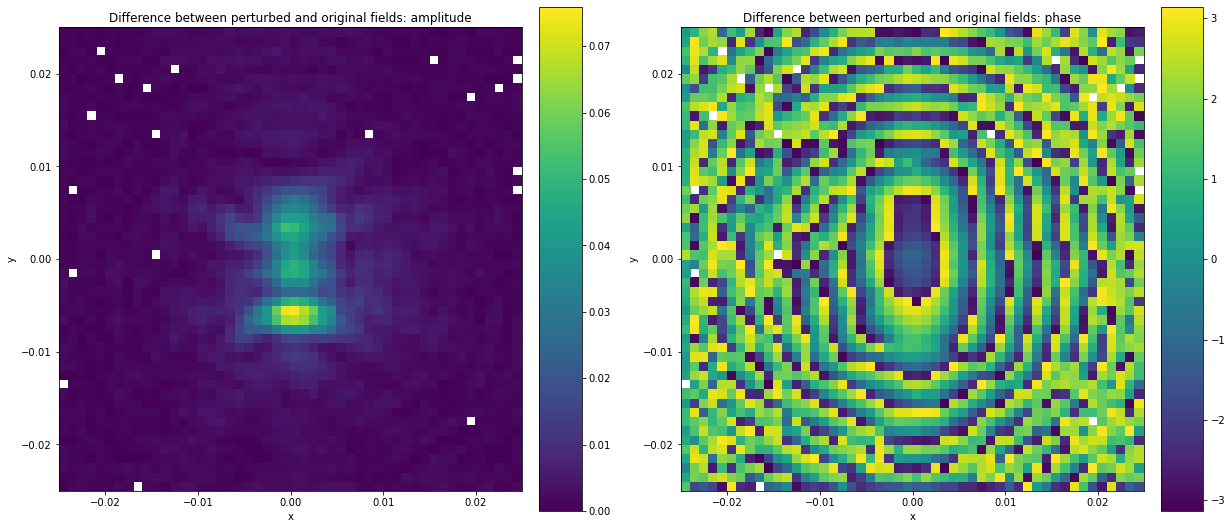

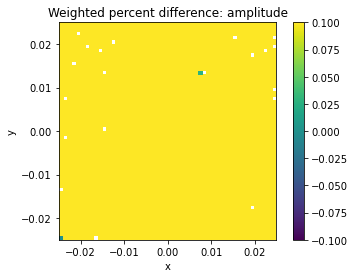

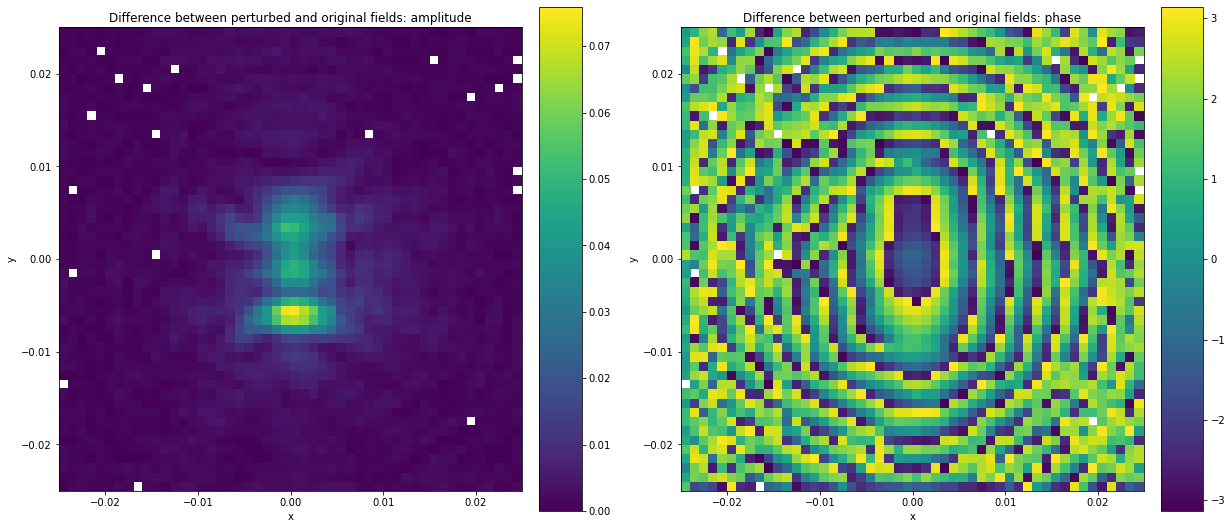

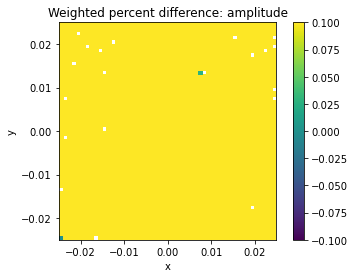

In [115]:
error_metrics=electric_field_errors(NF_X_Complex,NF_X_Drifted,x,y,'x','y',outputs=1)
error_metrics=electric_field_errors1(NF_X_Complex,NF_X_Drifted,x,y,'x','y',outputs=1)

In [113]:
print(error_metrics['weighted_percent_difference_amplitude_mean'])
print(error_metrics['weighted_percent_difference_phase_mean'])
print(error_metrics['weighted_percent_difference_mean_phase'])

14.180278757018423
-0.9740703567429537
-1.2116387427415123


In [114]:
error_metrics

{'error': array([[ 2.71050543e-20+2.16840434e-19j, -2.93323200e-04-1.25442040e-03j,
          3.88375300e-04-1.79726780e-03j, ...,
          3.00487600e-04-7.75728300e-04j, -2.48968600e-04-2.30632210e-03j,
         -1.08420217e-19-1.08420217e-19j],
        [ 4.00403300e-04+2.56451300e-04j, -1.87907700e-04+7.15825500e-04j,
         -1.23775000e-05+1.27470650e-03j, ...,
         -7.82330000e-05+1.59116480e-03j, -8.90965000e-05+3.25138700e-04j,
         -5.28673000e-04-5.37386700e-04j],
        [ 1.76561030e-03-6.10837800e-04j, -2.33545400e-04+1.13348130e-03j,
         -9.27648400e-04+7.64660300e-04j, ...,
         -6.43772400e-04+7.83367500e-04j,  8.20211600e-04+3.04031700e-04j,
         -3.65766410e-04+8.09501100e-04j],
        ...,
        [ 9.82143900e-04+5.97530370e-04j, -1.36290300e-03+7.93549000e-05j,
         -9.93566000e-05+4.62530300e-04j, ...,
         -4.04164994e-04-6.79419200e-04j, -4.29062000e-04-5.28711400e-04j,
         -8.42499000e-04+7.36584300e-04j],
        [ 1.276313